## CSCE 676 :: Data Mining and Analysis :: Texas A&M University :: Spring 2026


# Weekly Homework 6: Clustering


***Goals of this homework:***
* Understand why clustering is used in unsupervised learning.
* Apply and compare k-means and DBSCAN.
* Recognize strengths/weaknesses of each method based on data shape, density, and noise.
* Choose parameters appropriately.
* Evaluate clustering quality using quantitative metrics rather than visuals alone.


***Submission instructions:***

You should post your notebook to Canvas (look for the assignment there). Please name your submission **your-uin_hw6.ipynb**, so for example, my submission would be something like **555001234_hw6.ipynb**. Your notebook should be fully executed when you submit ... so run all the cells for us so we can see the output, then submit that.

***Grading philosophy:***

We are grading reasoning, judgment, and clarity, not just correctness. Show us that you understand the data, the constraints, and the limits of your conclusions.

***For each question, you need to respond with 2 cells:***
1. **[A Code Cell] Your Code:**
  - If code is not applicable for the question, you can skip this cell.
  - For tests: tests can be simple assertions or checks (e.g., using `assert` or `print` or small functions or visual inspection); formal testing frameworks are not required.
2. **[A Markdown Cell] Your Answer:** Write up your answers and explain them in complete sentences. Include any videos in this section as well; for videos, upload them to your TAMU Google Drive, and ensure they are set to be visible by the instruction team (set to: **anyone with a TAMU email can view**), then share the link to the video in the cell.

***At the end of each Section (A/B/C/...) include a cell for your resources:***

**[A Markdown Cell] Your Resources:** You need to cite 3 types of resources and note how they helped you: (1) Collaborators, (2) Web Sources (e.g. StackOverflow), and (3) AI Tools (you must also describe how you prompted, but we do not require any links to any specific chats). Specifically, use the following format as a template:
```
On my honor, I declare the following resources:
1. Collaborators:
- Reveille A.: Helped me understand that a df in pandas is a data structure kinda like a CSV.
- Sully A.: Helped me fix a bug with the vector addition of 2 columns.
- ...

2. Web Sources:
- https://stackoverflow.com/questions/46562479/python-pandas-data-frame-creation: how to create a pd df
- ...

3. AI Tools:
- ChatGPT: I gave it the homework .ipynb file and the ufo.csv, and told it to generate the code for the first question, but it did it with csv.reader(), so I re-prompted it to use pandas and that one was correct
- ...
```
***Why do we require this cell?*** This cell is important...

1. For academic integrity, you must give credit where credit is due.

2. We want you to pay attention to how you can successfully get help to move through problems! Is there someone you work with or an AI tool that helps you learn the material better? That's great! The point of engineering is to use your tools to solve hard problems, and part of graduate school is learning about how *you* learn and solve problems best.

***A reminder: you get out of it what you put into it.***
Do your best on these homeworks, show us your creativity, and ask for help when you need it -- good luck!

# A [60pts]. Decision Trees

**Rubric**

[10 pts] Strong/Professional: Correct and complete implementation of the task; Reasonable assumptions, stated or implied, and justified; Thoughtful handling of real-world data issues (missingness, noise, scale, duplicates, edge cases); Clear, concise explanations of what was done and why; Code is clean, readable, and well-structured, uses appropriate pandas, and would plausibly pass a professional code review; Tests meaningfully validate non-trivial behavior (not just "the code runs so it must be right").

[5 pts] Partial/Developing: Core task mostly completed but with gaps, weak assumptions, or minor mistakes; Reasoning is shallow or mostly descriptive; Code works but is messy, repetitive, or fragile; Tests are superficial, incomplete, or poorly motivated.

[0 pts] Minimal/Incorrect: Task is largely incorrect, missing, or misunderstands the goal; Little to no reasoning or justification; Code does not run or ignores constraints; No meaningful tests.


## Environment Setup & Sampling (Optional)

- You may use the full datasets. Sampling is optional (for speed).
- If you sample, briefly report what you did (n/frac, whether you stratified, any seed).


In [1]:
#!/bin/bash
Jeopardy_data_URL ='https://www.kaggle.com/datasets/tunguz/200000-jeopardy-questions'

In [2]:
###### sampling code (optional)
from pathlib import Path
import pandas as pd

# Edit paths if needed
JEOPARDY_PATH = Path("JEOPARDY_CSV-2.csv")

def load_csv(path, **kwargs):
    if path.exists():
        return pd.read_csv(path, **kwargs)
    print(f"Warning: {path} not found.")
    return None

jeopardy = load_csv(JEOPARDY_PATH)

# ====== (Optional) Sampling ======
# Leave all values as None to use the full dataset.
SAMPLE = {
    "jeopardy": {"n": None, "frac": None, "random_state": None, "stratify_col": None},  # e.g., {"n": 20000, "random_state": 42}
}

def maybe_sample(df, cfg):
    """Return sampled df if n/frac set; otherwise return df. Optional stratify by a column name."""
    if df is None:
        return None
    n, frac, rs, strat = cfg.get("n"), cfg.get("frac"), cfg.get("random_state"), cfg.get("stratify_col")
    if strat and strat in df.columns and (n or frac):
        # stratified sampling (simple & proportional when using frac)
        if frac:
            return (df.groupby(strat, group_keys=False)
                      .apply(lambda g: g.sample(frac=frac, random_state=rs))
                      .reset_index(drop=True))
        # proportional n by class frequency (rounded)
        counts = df[strat].value_counts(normalize=True) * n
        parts = []
        for k, need in counts.round().astype(int).items():
            part = df[df[strat]==k].sample(n=min(need, len(df[df[strat]==k])), random_state=rs)
            parts.append(part)
        out = pd.concat(parts).reset_index(drop=True)
        return out.sample(frac=1.0, random_state=rs).reset_index(drop=True)
    # simple sampling
    if frac: return df.sample(frac=frac, random_state=rs).reset_index(drop=True)
    if n:    return df.sample(n=min(n, len(df)), random_state=rs).reset_index(drop=True)
    return df.reset_index(drop=True)

jeopardy_sample = maybe_sample(jeopardy, SAMPLE["jeopardy"])

print("Jeopardy:", None if jeopardy is None else jeopardy.shape,
      "-> sample:", None if jeopardy_sample is None else jeopardy_sample.shape)

Jeopardy: (216930, 7) -> sample: (216930, 7)


# 1. Text Cleaning

_Jeopardy!_ is a popular U.S. quiz show where contestants are given answers and must respond with the questions.
> For example: Answer: “This planet is known as the Red Planet.” Correct question: “What is Mars?”

In this dataset, each question has a Category (topic), Question (text), and Answer (label).
You will analyze patterns in these texts and explore how question wording relates to categories and answers.

- Clean the text (e.g., lowercase, remove stopwords/punctuation, optional stemming or lemmatization). You may use any pipeline you like, including optional TF-IDF features, embeddings, or whatever you like. Many packages (e.g., sklearn) come built in with some nice text processing packages.

- Write at least 2 tests for your code (focus on the most complicated parts), then answer: What did you test for? How do you know your code is correct?

- Briefly explain your design choices (what steps or parameters you used) and give a short rationale (why you think these choices help).



In [3]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk

nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    # 1. Lowercase
    text = text.lower()
    
    # 2. Remove punctuation
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 3. Tokenize
    tokens = text.split()
    
    # 4. Remove stopwords
    tokens = [t for t in tokens if t not in ENGLISH_STOP_WORDS]
    
    # 5. Lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    
    # 6. Rejoin
    return " ".join(tokens)

def preprocess_jeopardy(df):
    df.columns = df.columns.str.strip()
    df["Question"] = df["Question"].apply(clean_text)
    df["Category"] = df["Category"].apply(clean_text)
    df["Answer"] = df["Answer"].apply(clean_text)
    return df


def problem1():
    preprocess_jeopardy(jeopardy_sample)

problem1()

def test_punctuation_and_lowercase():
    input_text = "This Planet is Known as the Red Planet!"
    cleaned = clean_text(input_text)
    assert "!" not in cleaned
    assert cleaned == cleaned.lower()
    
def test_stopwords_and_lemmatization():
    input_text = "Cats are running in the gardens"
    cleaned = clean_text(input_text)
    expected_words = ["cat", "running", "garden"]  # after stopword removal
    for word in expected_words:
        assert word in cleaned
    assert "the" not in cleaned
    assert "are" not in cleaned

test_punctuation_and_lowercase()
test_stopwords_and_lemmatization()

[nltk_data] Downloading package wordnet to /home/keegan-
[nltk_data]     smith/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/keegan-
[nltk_data]     smith/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


I tested for removal of punctuation and for the removal of stop words and lemmatization. I know my code is likely correct because these two random strings were successfully processed.  
I performed very basic string processing: converted to lowercase to ensure a word like aArDvArk == aardvark, e.g the case of a word usually doesn't have much to do with its semantic meaning. I also removed any characters which weren't a-z as they too should not change the semantic meaning of the text. I then removed Stop words which are high frequency words that don't hold a lot of semantic weight, like "the". Finally I did lemmatization, which is essentially converting synonyms to the same base word. E.g better becomes "good". I think these choices help because they filter out words that don't contribute to the semantic meaning of the text, which helps reduce noise, and also aggregates similar words together which allows for easier analysis since there aren't as many unique tokens.

***These next few parts are designed so you can observe the challenges of evaluating clustering.***

# 2. Evaluating **K-Means** with Metrics

- Run K-Means.
- Report some clustering metrics to assess the quality of clustering (you may consider the Silhouette score for each method, or perhaps `ARI` and `NMI` using the Category labels as ground truth).
- For each metric, you should try a few parameter values to determine the best values for the dataset. Plot your results, and include: what value are you varying & what value are you measuring to estimate cluster quality?
- Write about: What is the best value of $k$ based on your data? Why? (Use your results to back up your answers.)

clustering...
clustering...
clustering...
clustering...
clustering...
clustering...
performing score eval...
performing score eval...
finished param = 10
finished param = 20
performing score eval...
finished param = 80
performing score eval...
finished param = 40
performing score eval...
finished param = 160
performing score eval...
finished param = 320
param=10, score=0.0502
param=20, score=0.0929
param=40, score=0.1361
param=80, score=0.1944
param=160, score=0.2065
param=320, score=0.2087


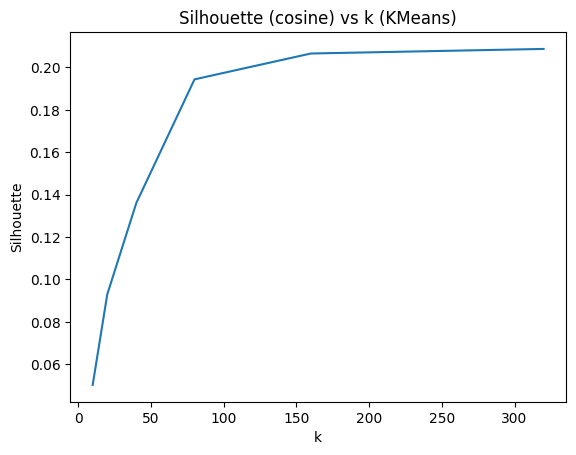

Recomputing labels for best k=320 (score=0.2087)


In [4]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
SIL_SIZE = 25000
# ---------- Shared feature builder ----------
def convert_to_cluster_X(df):
    q_vec = TfidfVectorizer(stop_words="english")
    X_q = q_vec.fit_transform(df["Question"])

    # c_vec = TfidfVectorizer(stop_words="english")
    # X_c = c_vec.fit_transform(df["Category"])

    # X = hstack([X_q, X_c])
    # print(X.shape[1])
    X = X_q
    svd = TruncatedSVD(n_components=200, random_state=42)
    norm = Normalizer(copy=False)
    X_reduced = make_pipeline(svd, norm).fit_transform(X)
    return X_reduced


# ---------- Generic clustering runner ----------
def run_cluster_and_score(
    X,
    clusterer_fn,          # function like: fn(X, **cluster_kwargs) -> labels
    score_fn=None,         # function like: score_fn(X, labels) -> float (optional)
    cluster_kwargs=None,   # kwargs passed to clusterer_fn
):
    cluster_kwargs = cluster_kwargs or {}
    print("clustering...", flush=True)
    labels = clusterer_fn(X, **cluster_kwargs)

    if score_fn is None:
        return labels, None
    print("performing score eval...", flush=True)
    score = score_fn(X, labels)
    return labels, score


# ---------- Generic parallel sweep + plot ----------
def parallel_sweep_and_plot(
    df,
    param_values,
    clusterer_fn,
    make_cluster_kwargs,
    score_fn,
    n_jobs=6,
    title="Score vs Parameter",
    xlabel="Parameter",
    ylabel="Score",
):
    df_clean = preprocess_jeopardy(df)
    X = convert_to_cluster_X(df_clean)

    def _one(v):
        _, score = run_cluster_and_score(
            X,
            clusterer_fn=clusterer_fn,
            score_fn=score_fn,
            cluster_kwargs=make_cluster_kwargs(v),
        )
        print("finished param =", v, flush=True)
        return v, score

    results = Parallel(n_jobs=n_jobs, prefer="processes")(
        delayed(_one)(v) for v in param_values
    )
    results = sorted(results, key=lambda t: t[0])

    xs = [v for v, _ in results]
    ys = [s for _, s in results]

    for v, s in results:
        print(f"param={v}, score={s:.4f}")

    plt.figure()
    plt.plot(xs, ys)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

    # ---- pick best param (max score); skip None/NaN safely
    import numpy as np
    valid = [(v, s) for (v, s) in results if s is not None and np.isfinite(s)]
    if not valid:
        # no valid scores; return X but no "best"
        return results, X, None, None, None

    best_param, best_score = max(valid, key=lambda t: t[1])

    # ---- recompute labels for best param once (no process-transfer needed)
    print(f"Recomputing labels for best {xlabel}={best_param} (score={best_score:.4f})", flush=True)
    best_labels = clusterer_fn(X, **make_cluster_kwargs(best_param))

    return results, X, best_labels, best_param, best_score


# ---------- Pluggable: KMeans clusterer ----------
from sklearn.cluster import KMeans

def cluster_kmeans(X, **kwargs):
    # expects kwargs like: n_clusters, random_state, n_init
    model = KMeans(**kwargs)
    return model.fit_predict(X)


# ---------- Pluggable: silhouette scorer ----------
def silhouette_cosine(sample_size=50000, random_state=0):
    def _score(X, labels):
        return silhouette_score(
            X, labels,
            metric="cosine",
            sample_size=sample_size,
            random_state=random_state
        )
    return _score


# -------------------- Problem 2 (KMeans) --------------------
def problem2():
    k_values = [10, 20, 40, 80, 160, 320]

    # Only these two lines matter to switch methods later:
    clusterer_fn = cluster_kmeans
    make_kwargs = lambda k: {"n_clusters": k, "random_state": 0, "n_init": "auto"}

    score_fn = silhouette_cosine(sample_size=SIL_SIZE, random_state=0)

    parallel_sweep_and_plot(
        jeopardy_sample,
        param_values=k_values,
        clusterer_fn=clusterer_fn,
        make_cluster_kwargs=make_kwargs,
        score_fn=score_fn,
        n_jobs=6,
        title="Silhouette (cosine) vs k (KMeans)",
        xlabel="k",
        ylabel="Silhouette",
    )

problem2()

First of all, I realized that in order to perform clustering I would need to convert the text to features, for this I used TF-IDF which converts the tokens to features and assigns each feature a score. The score is related to the frequency in that, if a feature appears frequently across all rows, then it has a lower score, and vice versa. I then used Truncated Singular Value Decomposition to reduce the number of features to 200, just to make it more computationally feasible. I used SVD instead of PCA because SVD works efficiently with sparse matrices, which is what we have.  

I used the Silhouette score as the metric for determining how good the clustering is. I varied k, the number of clusters, in order to determine the best value of k.  
From my graph, it would appear that k = 160 maximizes the Silhouette score, the maximum silouhette score achieved was .2205. 

# 2. Evaluating **DBSCAN** with Metrics

- Run DBSCAN.
- Report some clustering metrics to assess the quality of clustering (you may consider the Silhouette score for each method, or perhaps `ARI` and `NMI` using the Category labels as ground truth).
- For each metric, you should try a few parameter values to determine the best values for the dataset. Plot your results, and include: what value are you varying & what value are you measuring to estimate cluster quality?
- Write about: What are the best values based on your data? Why? (Use your results to back up your answers.)

In [ ]:
from sklearn.cluster import DBSCAN
os.environ["OMP_NUM_THREADS"] = "16"
os.environ["MKL_NUM_THREADS"] = "16"
def cluster_dbscan(X, **kwargs):
    model = DBSCAN(**kwargs)
    return model.fit_predict(X)

def problem3():
    eps_values = [0.30, .35, .4, .45, .5]

    # Only change these two lines (clusterer_fn + kwargs builder):
    clusterer_fn = cluster_dbscan
    make_kwargs = lambda eps: {"eps": eps, "min_samples": 10, "metric": "euclidean"}

    # Note: silhouette requires >=2 clusters and no single-cluster result.
    # You may want a "safe" score_fn that returns None if invalid.
    score_fn = silhouette_cosine(sample_size=SIL_SIZE, random_state=0)

    parallel_sweep_and_plot(
        jeopardy_sample,
        param_values=eps_values,
        clusterer_fn=clusterer_fn,
        make_cluster_kwargs=make_kwargs,
        score_fn=score_fn,
        n_jobs=6,
        title="Silhouette (cosine) vs eps (DBSCAN)",
        xlabel="eps",
        ylabel="Silhouette",
    )

problem3()

I am varying the epsilon parameter which is the maximum distance for a point to be considered a neighbor in DBScan. As we can see, the general trend is the silouhette score increases with the epsilon value. Unfortunately, increasing epsilon past .300 is computationally infeasible for my setup. Just getting this to run took ~15 minutes. I am using the Silouhette metric again because that is what I used for evaluating K-means so that I can compare the two clustering algorithms.  
The best value for epsilon based on my data above is epsilon = .3 which achieves a silouhette score of -.2830.

# 3. Comparing K-Means and DBSCAN **with Metrics**

- Compare your K-Means and DBSCAN results, and defend: If you had to choose one for this dataset, which one would you choose? Why? (Use your results to back up your answer.)
- The labels (categories) in this dataset are very sparse; however, your data has a useful property: e.g., categories might be 1800s British Literature, British Writers, British Lit --> those are three different labels even though they may conceptually be the same thing. Think about and answer: how could you exploit this property in your evaluation setup?

I would use K-Means simply because not only did it perform better, but the run time is much more manageable. K-Means took one tenth of the time to run compared to DBScan and achieved much better results. K means achieved a silouhette score of .5 whereas DBscan only achieved -.283.  
You could exploit this property by performing lemmatization on the categories which combines synonyms into the same word, thus words like Literature and Lit would be the same label. This make the labels much less sparse while still maintaining the semantic meanings of the categories.

# 4. Comparing K-Means and DBSCAN **Visually with PCA**

- For K-Means and DBSCAN, visualize the clusters in 2D with PCA
- Try a few parameter values to determine the best values for the dataset. Plot your results, and include: what value are you varying & what do you see in the plot (+ what does this lead you to conclude about cluster quality based on the visualization)?
- Write about: What are the best values based on your data? Why? (Use your results to back up your answers.)

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def plot_clusters_2d(X, labels, title="Cluster Visualization", dbscan = False):
    pca = PCA(n_components=2, random_state=42)
    X_2d = pca.fit_transform(X)

    plt.figure(figsize=(8,6))
    if(!dbscan):
        scatter = plt.scatter(
            X_2d[:, 0],
            X_2d[:, 1],
            c=labels,
            cmap="tab20",
            s=5,
            alpha=0.6
        )
    else:
        noise_mask = labels == -1
        plt.scatter(X_2d[noise_mask, 0], X_2d[noise_mask, 1], color="gray", s=5, alpha=0.3, label="Noise")
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.colorbar(scatter)
    plt.show()

def problem4():
    X = convert_cluster_X(jeopardy_sample)
    

# 5. Comparing K-Means and DBSCAN **Visually with t-SNE**

- For K-Means and DBSCAN, visualize the clusters in 2D with t-SNE
- Try a few parameter values to determine the best values for the dataset. Plot your results, and include: what value are you varying & what do you see in the plot (+ what does this lead you to conclude about cluster quality based on the visualization)?
- Write about: What are the best values based on your data? Why? (Use your results to back up your answers.)

# 6. Comparing K-Means and DBSCAN **with Visualization**
- Compare your K-Means and DBSCAN results, and defend: If you had to choose one for this dataset, which one would you choose? Why? (Use your results to back up your answer.)

# B [32pts]. Interview Questions

We now pretend this is a real job interview. Here's some guidance on how to answer these questions:

1. Briefly restate the question and state any assumptions you are making.

2. Explain your reasoning out loud, focusing on tradeoffs, limitations, and constraints.

3. As a principle, keep your answers as short and clear as they can be (while still answering the question).

4. Write/speak in a conversational but professional tone (avoid being overly formal). For speaking: speak at a reasonable pace and volume, speak clearly, pause when you need to, and practice making "eye contact" with the camera. Keep a confident, positive, and professional tone. *For additional coaching and practice, the University Writing Center provides individual appointments: https://writingcenter.tamu.edu/make-an-appointment.*

There may not be a single correct answer. We are grading whether your reasoning is reasonable and aware of limitations.


**Rubric**

[4pt] Clear understanding of the question; reasonable assumptions; thoughtful reasoning that acknowledges tradeoffs and limitations; clear, concise communication in a conversational but professional tone (for speaking: clear pace, volume, and articulation).

[2pt] Basic understanding but shallow reasoning or unclear assumptions; communication is somewhat unclear, overly verbose, or overly informal/formal.

[0pt] Minimal, unclear, or incorrect response; poor communication or unprofessional tone.

# 1.
How many metrics do you need to use to justify your clustering approach?

# 2.
What does it mean for clusters to be “real” if different algorithms produce different partitions of the same dataset?

# 3.
When is the question “how many clusters exist?” fundamentally ill-posed?

# 4.
Explain how every clustering algorithm encodes an implicit definition of similarity.

# 5.
What metrics would you monitor in production to detect clustering drift?


# 6.
Design a system that automatically groups incoming customer support tickets into topics in real time. What components exist from ingestion → preprocessing → embedding → clustering → serving?

# 7.
You have limited memory but a very large dataset — how do you cluster it?

# 8.
What happens if data distribution shifts drastically (e.g., breaking news topic spike)?

# 9.
(Video; 1 minute max) What happens if data distribution shifts drastically (e.g., breaking news topic spike)?

# C [4pts]. What new questions do you have?
We want you to think bigger! Tell us what questions and curiosity this homework brings up for you.

**Rubric**

[4pt] Complete, thoughtful response.

[2pt] Partial response.

[0pt] Minimal response.

# 1.
What new questions do you have after this homework? Or, what topics are you curious about now? List at least 3.